In [11]:
# Basic Libraries
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Deep Learning Pytorch Library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, TensorDataset, DataLoader
torch.cuda.is_available()
torch.cuda.empty_cache()

In [12]:
# Seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Pre-Processing Elements

In [121]:
# Sliding Window Function
# input: features, labels, sequence length
# outputs: sets of features and labels sequentialy

def sliding_windows(data1, data2, seq_length):
    x = []
    y = []

    for i in range(len(data1)-seq_length-1):
        _x = data1[i:(i+seq_length)] # input: the seq_length of data
        _y = data2[i+seq_length] #Output: the next value after the input 
        x.append(_x)
        y.append(_y)
        
    return np.array(x),np.array(y)

# this function take as arguments the data and a certain sequence length and append to an x an y variable the respective 
# previous data and the value that needs to be predicted

In [122]:
seq_length = 3

In [346]:
# Import dataset dimensions
dims_file = loadtxt('ota1_dimensions.csv')

# Import waves dataset
df = pd.read_csv('ota1_lna1_90_cf1.csv')

In [347]:
training_set_param_ca3 = df[['vip', 'vop']].values
training_set_param_ca3 = scaler.fit_transform(training_set_param_ca3)
training_set_labels_ca3 = df[['out+', 'out-']].values
training_set_labels_ca3 = scaler.fit_transform(training_set_labels_ca3)

x_ca3, y_ca3 = sliding_windows(training_set_param_ca3, training_set_labels_ca3, seq_length)

if np.size(x_ca3,0) % 2 != 0:
    x_ca3 = np.delete(x_ca3, -1, 0)

# Normalize the dimensions
#dims_file = scaler.fit_transform(dims_file)

In [348]:
# Define all dataset for train
all_dataX = Variable(torch.Tensor(np.array(x_ca3)))
all_dataY = Variable(torch.Tensor(np.array(y_ca3)))

# Define the dimensions input
dims = dims_file[92]
dims = np.tile(dims, (x_ca3.shape[0], 1))
dimension_input = Variable(torch.Tensor(np.array(dims)))

# Define the evaluation batchsize
BatchSize = np.size(x_ca3,0)

# Import the Model

In [349]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, batch_size):
        super(LSTM, self).__init__()
        
        # Define Variables to be used in the "forward" path
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.batch_init_states = int(batch_size/2)

        # initialize the hidden and cell states - Stateful LSTM
        self.hn = Variable(torch.zeros(1, self.batch_init_states, 450).cuda())
        self.cn = Variable(torch.zeros(1, self.batch_init_states, 450).cuda())
        
        # Define the layers that will be used
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # LSTM Layer
        self.fc1 = nn.Linear(hidden_size + 28, 250) # First Linear layer (+ 28 because of the 28 features for the dimensions for the devices) 250
        self.elu = nn.ELU() # Activation function to allows the model to destinguish de dimensions
        self.dropout = nn.Dropout(p = 0.1) # Dropout to regularization
        self.fc2 = nn.Linear(250, num_classes) # Second Linear Layer
        self.fc3 = nn.Linear(28, num_classes) # Second Linear Layer

    def forward(self, x, dimensions):
        
        # Propagate the input through LSTM module
        ula, (self.hn, self.cn) = self.lstm(x, (self.hn.cuda(), self.cn.cuda()))
             
        # Ajust lstm output shape
        hn_out = (self.hn).view(-1, self.hidden_size)

        # Concatenate the lstm output and the dimension vector
        in_fc = torch.cat((hn_out.cuda(), dimensions.cuda()), dim=1).cuda()

        # Propagate the data through the fully conected layers
        out = self.fc1(in_fc)
        out = self.elu(out)
        out = self.fc2(out)
        
        return out

In [350]:
lstm = LSTM(num_classes=2, input_size=2, hidden_size=450, num_layers=1, batch_size = BatchSize).cuda() #have 200 450!!
lstm = torch.nn.DataParallel(lstm, device_ids=[0,1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=0.00005) #0.0001

checkpoint = torch.load('/home/aamaral/Desktop/BigDataset/Evaluation/Nada.pt')
lstm.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [351]:
with torch.no_grad():
    lstm.eval()
    test_predict = lstm(all_dataX, dimension_input)

In [352]:
# Convert the train prediction and the train label to numpy vectors
test_predict = test_predict.cpu().data.numpy()
test_predict = scaler.inverse_transform(test_predict)
test_label_plot = all_dataY.cpu().numpy()

if np.size(test_label_plot,0) % 2 != 0:
    test_label_plot = np.delete(test_label_plot, -1, 0)

test_label_plot = scaler.inverse_transform(test_label_plot)

# Add noise to the predictions
errors_mean = -0.00004383777
errors_stdv = 0.00025118375
noise = np.random.normal(errors_mean,errors_stdv, test_predict.shape) # Create a gaussian noise 
test_predict = test_predict - noise

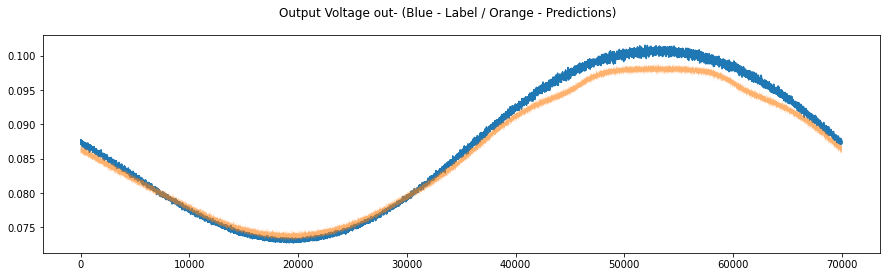

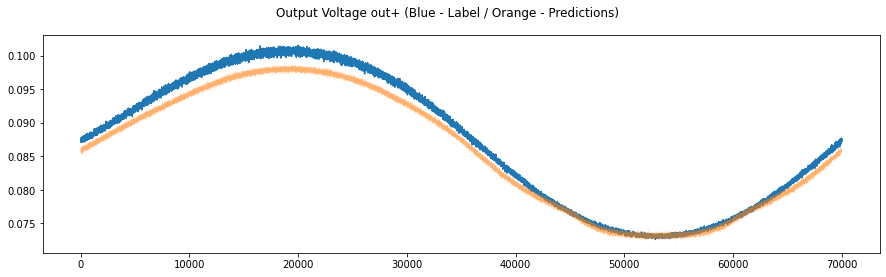

In [353]:
# Plot the graphics with the results
plt.figure(figsize=(15,4))
plt.plot(test_label_plot[:,0])
plt.plot(test_predict[:,0], linewidth=0.09,alpha=0.6)
plt.suptitle('Output Voltage out- (Blue - Label / Orange - Predictions)')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(test_label_plot[:,1])
plt.plot(test_predict[:,1],  linewidth=0.09,alpha=0.6)
plt.suptitle('Output Voltage out+ (Blue - Label / Orange - Predictions)')
plt.show()

In [354]:
loss = np.sqrt(np.mean(np.power(abs(test_predict[:,0] - test_label_plot[:,0]),2)))

In [355]:

loss

0.0015005392877610391

In [356]:
np.mean(np.power(abs(test_predict[:,0] - test_label_plot[:,0]),2))

2.2516181541144064e-06